<a href="https://colab.research.google.com/github/Alfonso-Jesus-Garcia-Moya/NLP_Analisis-de-Sentimientos_en_X_o_Twitter_InterTASS/blob/main/InterTASS_y_Emo_(An%C3%A1lisis_de_Sentimientos).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fase 1. Preparación y exploración de datos
1.	Cargar los datasets (InterTASS y EmoEvent) en formato CSV y XML.
2.	Explorar la distribución de clases (porcentaje de tweets positivos, negativos, etc.).
3.	Visualizar ejemplos de cada categoría.


🔄 Procesando Sentimientos (XML) desde: /content/data/general-train-tagged.xml...
🔄 Procesando Emociones (CSV) desde: /content/data/emoevent_es.csv...

✅ AMBOS DATASETS CARGADOS CORRECTAMENTE.
   - Sentimientos (InterTASS): 7219 tweets
   - Emociones (EmoEvent):     8409 tweets


/tmp/ipython-input-284768191.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df_sent, order=['P', 'N', 'NEU', 'NONE'], palette=colores_sent, ax=ax[0])
/tmp/ipython-input-284768191.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='label', data=df_emo, palette='magma',


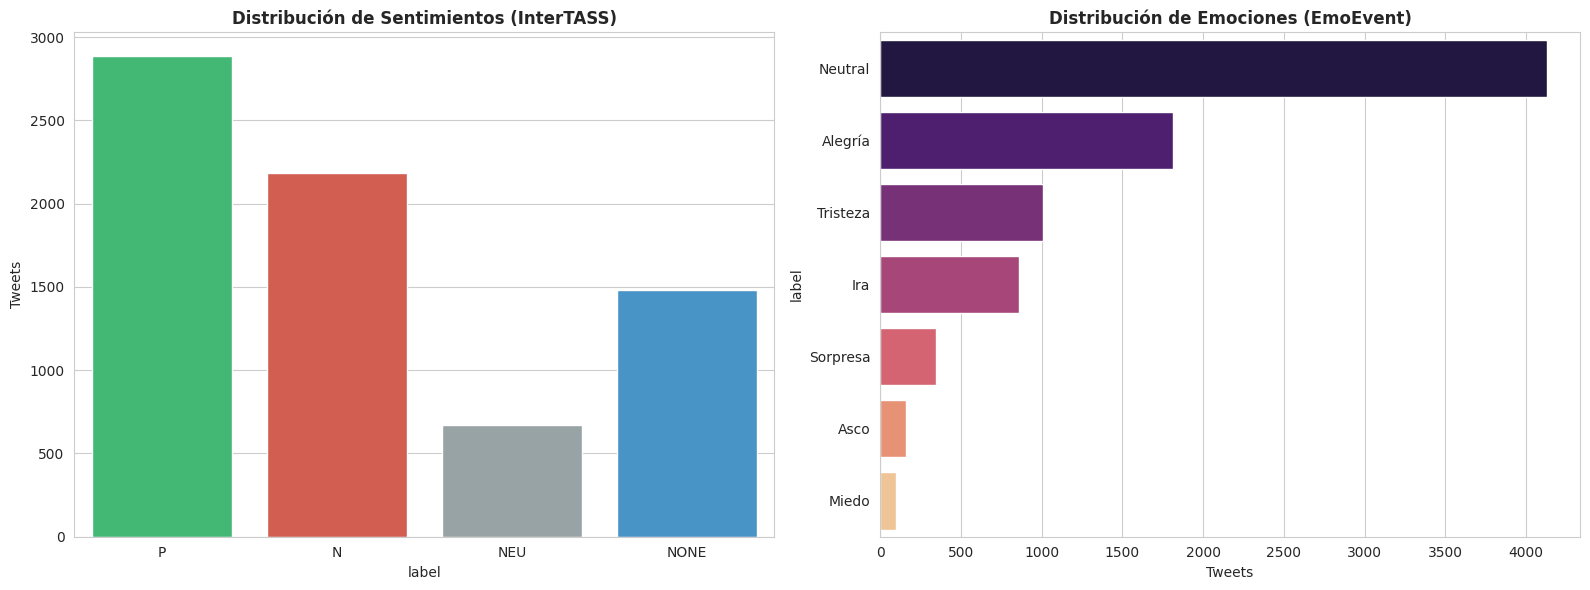


🔎 VISTA PREVIA DE DATOS UNIFICADOS:
--- InterTASS (Sentimiento) ---
                                                             content label
0                        Salgo de #VeoTV , que día más largoooooo...  NONE
1  @PauladeLasHeras No te libraras de ayudar me/nos. Besos y gracias   NEU
2                                          @marodriguezb Gracias MAR     P

--- EmoEvent (Emoción) ---
                                                                                                                   content  \
0  Acabo de ver la gran pérdida que estamos teniendo en estos momentos en HASHTAG... La catedral de HASHTAG está en lla...   
1  USER ¿A que vamos a reconstruir Notre Dame antes de mandar un solo barco de salvamento al Mediterráneo... a que sí? ...   
2               Desde ayer andan sufriendo por el incendio de HASHTAG y ni siquiera conocen la Basílica del voto nacional.   

      label  
0  Tristeza  
1  Tristeza  
2       Ira  


In [7]:
# ==============================================================================
# FASE 1 MAESTRA: INGESTIÓN Y EDA SIMULTÁNEO (SENTIMIENTOS + EMOCIONES)
# ==============================================================================

# 1. Instalación de librerías (solo si no están)
try:
    import xmltodict
except ImportError:
    !pip install -q xmltodict
    import xmltodict

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuración visual global
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

# ==============================================================================
# A. DEFINICIÓN DE RUTAS Y FUNCIONES DE CARGA ESPECIALIZADAS
# ==============================================================================

# Rutas de tus archivos (Ajusta si cambian de nombre)
ruta_intertass = '/content/data/general-train-tagged.xml'  # Sentimientos
ruta_emoevent = '/content/data/emoevent_es.csv'            # Emociones

# Función 1: Carga XML Robusta (Para InterTASS - Sentimientos)
def cargar_sentimientos_xml(ruta):
    print(f"🔄 Procesando Sentimientos (XML) desde: {ruta}...")
    if not os.path.exists(ruta): return None, "Archivo no encontrado"

    with open(ruta, 'r', encoding='utf-8') as f:
        xml_content = f.read()

    data = xmltodict.parse(xml_content)

    # Navegación flexible por la estructura XML
    if 'tweets' in data: tweets = data['tweets']['tweet']
    elif 'intertass' in data: tweets = data['intertass']['tweet']
    else: tweets = data[list(data.keys())[0]]['tweet']

    rows = []
    for t in tweets:
        try:
            # Extracción de Sentimiento (Polaridad)
            sent_node = t['sentiments']['polarity']
            label = None

            # Lógica para encontrar la etiqueta global (sin 'entity')
            if isinstance(sent_node, list):
                for item in sent_node:
                    if 'entity' not in item:
                        label = item['value']
                        break
                if not label: label = sent_node[0]['value']
            elif isinstance(sent_node, dict):
                label = sent_node['value']

            # Normalización (P+ -> P, N+ -> N)
            if label == 'P+': label = 'P'
            if label == 'N+': label = 'N'

            # Filtrado estricto
            if label in ['P', 'N', 'NEU', 'NONE']:
                rows.append({'content': t['content'], 'label': label})
        except: continue

    return pd.DataFrame(rows), "OK"

# Función 2: Carga CSV Robusta (Para EmoEvent - Emociones)
def cargar_emociones_csv(ruta):
    print(f"🔄 Procesando Emociones (CSV) desde: {ruta}...")
    if not os.path.exists(ruta): return None, "Archivo no encontrado"

    try:
        # Intentamos leer con tabulador primero
        df = pd.read_csv(ruta, sep='\t')
        if len(df.columns) < 2: df = pd.read_csv(ruta, sep=',') # Fallback a coma

        # Renombrar columnas para estandarizar (buscamos 'tweet' y 'emotion')
        df.rename(columns={'tweet': 'content', 'emotion': 'label'}, inplace=True)

        # Mapeo Inglés -> Español (Tus 7 clases objetivo)
        mapa = {
            'joy': 'Alegría', 'sadness': 'Tristeza', 'anger': 'Ira',
            'disgust': 'Asco', 'fear': 'Miedo', 'surprise': 'Sorpresa',
            'others': 'Neutral', 'neutral': 'Neutral' # 'others' suele ser Neutral
        }
        df['label'] = df['label'].map(mapa)

        # Filtrar nulos (etiquetas no mapeadas)
        df_clean = df.dropna(subset=['label'])[['content', 'label']]
        return df_clean, "OK"

    except Exception as e: return None, str(e)

# ==============================================================================
# B. EJECUCIÓN SIMULTÁNEA DE CARGAS
# ==============================================================================

# 1. Cargar Sentimientos (InterTASS)
df_sent, status_sent = cargar_sentimientos_xml(ruta_intertass)

# 2. Cargar Emociones (EmoEvent)
df_emo, status_emo = cargar_emociones_csv(ruta_emoevent)

# ==============================================================================
# C. VISUALIZACIÓN COMPARATIVA (DASHBOARD)
# ==============================================================================

if (df_sent is not None) and (df_emo is not None):
    print("\n✅ AMBOS DATASETS CARGADOS CORRECTAMENTE.")
    print(f"   - Sentimientos (InterTASS): {len(df_sent)} tweets")
    print(f"   - Emociones (EmoEvent):     {len(df_emo)} tweets")

    # Crear dashboard de 2 gráficas
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    # Gráfica 1: Sentimientos
    colores_sent = {'P': '#2ecc71', 'N': '#e74c3c', 'NEU': '#95a5a6', 'NONE': '#3498db'}
    sns.countplot(x='label', data=df_sent, order=['P', 'N', 'NEU', 'NONE'], palette=colores_sent, ax=ax[0])
    ax[0].set_title('Distribución de Sentimientos (InterTASS)', fontsize=12, fontweight='bold')
    ax[0].set_ylabel('Tweets')

    # Gráfica 2: Emociones
    sns.countplot(y='label', data=df_emo, palette='magma',
                  order=df_emo['label'].value_counts().index, ax=ax[1])
    ax[1].set_title('Distribución de Emociones (EmoEvent)', fontsize=12, fontweight='bold')
    ax[1].set_xlabel('Tweets')

    plt.tight_layout()
    plt.show()

    # Muestreo rápido de datos
    print("\n🔎 VISTA PREVIA DE DATOS UNIFICADOS:")
    print("--- InterTASS (Sentimiento) ---")
    print(df_sent.head(3))
    print("\n--- EmoEvent (Emoción) ---")
    print(df_emo.head(3))

else:
    print(f"❌ ERROR CRÍTICO:")
    print(f"   - Estado Sentimientos: {status_sent}")
    print(f"   - Estado Emociones:    {status_emo}")

#Fase 2. Preprocesamiento de texto
•	Eliminación de URLs, menciones y hashtags.

•	Conversión a minúsculas y eliminación de signos de puntuación.

•	Tokenización y eliminación de stopwords.

•	Representación de los textos mediante:

o	TF-IDF para modelos clásicos (Logistic Regression).

o	Embeddings de BETO (BERT en español) para modelos de deep learning.


In [9]:
# ==============================================================================
# FASE 2: PREPROCESAMIENTO PROFUNDO Y VECTORIZACIÓN SIMULTÁNEA
# ==============================================================================

import re
import string
import nltk
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer

# 1. Descarga de recursos NLTK (Anti-fallos)
print("📥 Cargando recursos lingüísticos...")
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)

stop_words_es = set(stopwords.words('spanish'))

# ==============================================================================
# A. FUNCIÓN DE LIMPIEZA MAESTRA (AQUÍ ESTÁ LA CORRECCIÓN QUE PEDISTE)
# ==============================================================================

def limpieza_maestra(texto, estrategia="tfidf"):
    """
    Args:
        texto: El string original.
        estrategia: 'tfidf' (limpieza total) o 'beto' (limpieza estructural).
    """
    if not isinstance(texto, str): return ""

    # --- PASO 1: LIMPIEZA DE ARTEFACTOS ESPECÍFICOS (LO QUE ME PEDISTE) ---

    # 1.1 ELIMINACIÓN PARA EMOEVENT (Literalmente las palabras "USER" y "HASHTAG")
    # \b asegura que sea la palabra completa. flags=re.I ignora mayúsculas/minúsculas.
    texto = re.sub(r'\bUSER\b', '', texto, flags=re.IGNORECASE)
    texto = re.sub(r'\bHASHTAG\b', '', texto, flags=re.IGNORECASE)

    # 1.2 ELIMINACIÓN PARA INTERTASS (Símbolos @ y # y sus contenidos)
    texto = re.sub(r'@\w+', '', texto)  # Elimina @usuario completo
    texto = re.sub(r'#\w+', '', texto)  # Elimina #tema completo
    texto = re.sub(r'http\S+|www\.\S+', '', texto) # Elimina URLs

    # --- PASO 2: NORMALIZACIÓN ---

    # Eliminar espacios dobles generados por los borrados anteriores
    texto = re.sub(r'\s+', ' ', texto).strip()

    # Si es para BETO, paramos aquí (BETO necesita mayúsculas y puntuación para contexto)
    if estrategia == 'beto':
        return texto

    # --- PASO 3: LIMPIEZA PROFUNDA (SOLO PARA TF-IDF / LOGISTIC REGRESSION) ---

    # 3.1 Conversión a minúsculas
    texto = texto.lower()

    # 3.2 Eliminación de signos de puntuación (.,!?) y Números
    texto = texto.translate(str.maketrans("", "", string.punctuation + "¡¿"))
    texto = re.sub(r'\d+', '', texto)

    # 3.3 Tokenización (Cortar en palabras)
    tokens = word_tokenize(texto, language='spanish')

    # 3.4 Eliminación de Stopwords (el, la, de, que...)
    tokens_limpios = [t for t in tokens if t not in stop_words_es and len(t) > 1]

    return " ".join(tokens_limpios)

# ==============================================================================
# B. APLICACIÓN A LOS DOS DATASETS (SENTIMIENTOS Y EMOCIONES)
# ==============================================================================
print("\n⚙️ 1. Aplicando limpieza a ambos datasets...")

# Validamos que existan los dataframes de la Fase 1
if 'df_sent' not in globals() or 'df_emo' not in globals():
    raise ValueError("⚠️ Faltan los dataframes. Ejecuta la Fase 1 primero.")

# --- PROCESAMIENTO INTERTASS (SENTIMIENTOS) ---
df_sent['text_tfidf'] = df_sent['content'].apply(lambda x: limpieza_maestra(x, estrategia='tfidf'))
df_sent['text_beto'] = df_sent['content'].apply(lambda x: limpieza_maestra(x, estrategia='beto'))

# --- PROCESAMIENTO EMOEVENT (EMOCIONES) ---
df_emo['text_tfidf'] = df_emo['content'].apply(lambda x: limpieza_maestra(x, estrategia='tfidf'))
df_emo['text_beto'] = df_emo['content'].apply(lambda x: limpieza_maestra(x, estrategia='beto'))

print("   -> Limpieza completada.")
print("\n🔍 VERIFICACIÓN (Revisa que no haya #, @, USER o HASHTAG):")
print("--- InterTASS (Original vs TF-IDF) ---")
print(df_sent[['content', 'text_tfidf']].head(2))
print("\n--- EmoEvent (Original vs TF-IDF) ---")
print(df_emo[['content', 'text_tfidf']].head(2))

# ==============================================================================
# C. DIVISIÓN DE DATOS (TRAIN / TEST) PARA AMBOS
# ==============================================================================
print("\n✂️ 2. Dividiendo en Entrenamiento y Prueba (80/20)...")

# Mapas de etiquetas a números
labels_sent = sorted(df_sent['label'].unique())
map_sent = {l: i for i, l in enumerate(labels_sent)}
df_sent['label_id'] = df_sent['label'].map(map_sent)

labels_emo = sorted(df_emo['label'].unique())
map_emo = {l: i for i, l in enumerate(labels_emo)}
df_emo['label_id'] = df_emo['label'].map(map_emo)

# Split Sentimientos
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    df_sent, df_sent['label_id'], test_size=0.2, stratify=df_sent['label_id'], random_state=42
)

# Split Emociones
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(
    df_emo, df_emo['label_id'], test_size=0.2, stratify=df_emo['label_id'], random_state=42
)

print(f"   - Train Sentimientos: {len(X_train_s)} | Train Emociones: {len(X_train_e)}")

# ==============================================================================
# D. REPRESENTACIÓN 1: TF-IDF (MODELO CLÁSICO)
# ==============================================================================
print("\n🧮 3. Vectorizando con TF-IDF (Matriz Numérica)...")

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Vectorización Sentimientos (Fit solo en train)
X_train_tfidf_s = vectorizer.fit_transform(X_train_s['text_tfidf'])
X_test_tfidf_s = vectorizer.transform(X_test_s['text_tfidf'])

# Vectorización Emociones (Fit solo en train, reiniciando vectorizer para vocabulario nuevo)
vectorizer_emo = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf_e = vectorizer_emo.fit_transform(X_train_e['text_tfidf'])
X_test_tfidf_e = vectorizer_emo.transform(X_test_e['text_tfidf'])

print(f"   -> Matriz TF-IDF Sentimientos: {X_train_tfidf_s.shape}")
print(f"   -> Matriz TF-IDF Emociones:    {X_train_tfidf_e.shape}")

# ==============================================================================
# E. REPRESENTACIÓN 2: TOKENIZACIÓN BETO (DEEP LEARNING)
# ==============================================================================
print("\n🤖 4. Preparando Tokenizer BETO...")

tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

# Verificación rápida
ejemplo = X_train_e['text_beto'].iloc[0]
print(f"   -> Ejemplo Tokenizado (EmoEvent): {tokenizer.tokenize(ejemplo)[:10]}")

print("\n✅ FASE 2 COMPLETADA. Datasets limpios y listos.")

📥 Cargando recursos lingüísticos...

⚙️ 1. Aplicando limpieza a ambos datasets...
   -> Limpieza completada.

🔍 VERIFICACIÓN (Revisa que no haya #, @, USER o HASHTAG):
--- InterTASS (Original vs TF-IDF) ---
                                                             content  \
0                        Salgo de #VeoTV , que día más largoooooo...   
1  @PauladeLasHeras No te libraras de ayudar me/nos. Besos y gracias   

                            text_tfidf  
0                 salgo día largoooooo  
1  libraras ayudar menos besos gracias  

--- EmoEvent (Original vs TF-IDF) ---
                                                                                                                   content  \
0  Acabo de ver la gran pérdida que estamos teniendo en estos momentos en HASHTAG... La catedral de HASHTAG está en lla...   
1  USER ¿A que vamos a reconstruir Notre Dame antes de mandar un solo barco de salvamento al Mediterráneo... a que sí? ...   

                                   

#Fase 3. Entrenamiento del modelo
•	Modelo 1 (Sentimientos): entrenado con InterTASS
o	Algoritmo: Logistic Regression Y BETO.

o	Clases: P, N, NEU, NONE.

In [10]:
# ==============================================================================
# FASE 3: ENTRENAMIENTO DE MODELOS (SENTIMIENTOS Y EMOCIONES)
# ==============================================================================

import os
# --- FIX: DESACTIVAR WANDB PARA QUE NO PIDA API KEY ---
os.environ["WANDB_DISABLED"] = "true"

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
import numpy as np

# --- 1. VERIFICACIÓN DE GPU ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Usando dispositivo: {device}")
if device.type == 'cpu':
    print("⚠️ ¡ALERTA! Sigues en CPU. Activa T4 GPU para acelerar el proceso.")

# ==============================================================================
# [cite_start]PARTE A: MODELOS CLÁSICOS (Regresión Logística) [cite: 35]
# ==============================================================================
print("\n🧠 A. ENTRENANDO MODELOS CLÁSICOS (Regresión Logística)...")
print("-" * 70)

# --- A1. SENTIMIENTOS (INTERTASS) ---
print("   -> 1. Entrenando Sentimientos (InterTASS)...")
# Usamos las variables _s creadas en la Fase 2
clf_sent = LogisticRegression(
    C=1.0,
    solver='liblinear',
    class_weight='balanced', # Crucial para datos desbalanceados
    random_state=42,
    max_iter=1000
)
clf_sent.fit(X_train_tfidf_s, y_train_s)

# --- A2. EMOCIONES (EMOEVENT) ---
print("   -> 2. Entrenando Emociones (EmoEvent)...")
# Usamos las variables _e creadas en la Fase 2
clf_emo = LogisticRegression(
    C=1.0,
    solver='liblinear',
    class_weight='balanced',
    random_state=42,
    max_iter=1000
)
clf_emo.fit(X_train_tfidf_e, y_train_e)

print("✅ Modelos Clásicos listos.")

# ==============================================================================
# PARTE B: PREPARACIÓN DE DATOS PARA BETO (DEEP LEARNING)
# ==============================================================================
print("\n⚙️ B. PREPARANDO DATASETS PARA BETO (HUGGING FACE)...")

# Función de tokenización (Reutilizable)
def tokenizar_para_bert(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

# --- B1. SENTIMIENTOS ---
# Convertimos Pandas DataFrame a Dataset de Hugging Face
ds_train_s = Dataset.from_pandas(pd.DataFrame({'text': X_train_s['text_beto'], 'label': y_train_s}))
ds_test_s = Dataset.from_pandas(pd.DataFrame({'text': X_test_s['text_beto'], 'label': y_test_s}))
# Tokenizamos
tokenized_train_s = ds_train_s.map(tokenizar_para_bert, batched=True)
tokenized_test_s = ds_test_s.map(tokenizar_para_bert, batched=True)

# --- B2. EMOCIONES ---
ds_train_e = Dataset.from_pandas(pd.DataFrame({'text': X_train_e['text_beto'], 'label': y_train_e}))
ds_test_e = Dataset.from_pandas(pd.DataFrame({'text': X_test_e['text_beto'], 'label': y_test_e}))
# Tokenizamos
tokenized_train_e = ds_train_e.map(tokenizar_para_bert, batched=True)
tokenized_test_e = ds_test_e.map(tokenizar_para_bert, batched=True)

# Función de métricas (común para ambos)
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted') # Weighted por el desbalance
    return {'accuracy': acc, 'f1': f1}

# ==============================================================================
# PARTE C: ENTRENAMIENTO DE BETO (SENTIMIENTOS)
# ==============================================================================
print("\n🔥 C. ENTRENAMIENTO BETO: SENTIMIENTOS (INTERTASS)...")
print("-" * 70)

# Cargar BETO limpio para 4 clases (P, N, NEU, NONE)
model_beto_s = BertForSequenceClassification.from_pretrained(
    "dccuchile/bert-base-spanish-wwm-cased",
    num_labels=4
).to(device)

args_s = TrainingArguments(
    output_dir='./results_sent',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none" # Evita API Key
)

trainer_s = Trainer(
    model=model_beto_s,
    args=args_s,
    train_dataset=tokenized_train_s,
    eval_dataset=tokenized_test_s,
    compute_metrics=compute_metrics
)

trainer_s.train()
trainer_s.save_model("./modelo_beto_sentimientos") # Guardamos
print("✅ Modelo Sentimientos Guardado.")

# ==============================================================================
# PARTE D: ENTRENAMIENTO DE BETO (EMOCIONES)
# ==============================================================================
print("\n🔥 D. ENTRENAMIENTO BETO: EMOCIONES (EMOEVENT)...")
print("-" * 70)

# Detectamos cuántas emociones hay dinámicamente (deberían ser 7)
num_labels_emo = len(map_emo)

# Cargar BETO limpio para 7 clases
model_beto_e = BertForSequenceClassification.from_pretrained(
    "dccuchile/bert-base-spanish-wwm-cased",
    num_labels=num_labels_emo
).to(device)

args_e = TrainingArguments(
    output_dir='./results_emo',
    num_train_epochs=4, # Emociones es más difícil, damos una época extra
    per_device_train_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none"
)

trainer_e = Trainer(
    model=model_beto_e,
    args=args_e,
    train_dataset=tokenized_train_e,
    eval_dataset=tokenized_test_e,
    compute_metrics=compute_metrics
)

trainer_e.train()
trainer_e.save_model("./modelo_beto_emociones") # Guardamos
print("✅ Modelo Emociones Guardado.")

print("\n🎉 FASE 3 COMPLETADA: 4 MODELOS ENTRENADOS Y LISTOS.")

✅ Usando dispositivo: cuda

🧠 A. ENTRENANDO MODELOS CLÁSICOS (Regresión Logística)...
----------------------------------------------------------------------
   -> 1. Entrenando Sentimientos (InterTASS)...
   -> 2. Entrenando Emociones (EmoEvent)...
✅ Modelos Clásicos listos.

⚙️ B. PREPARANDO DATASETS PARA BETO (HUGGING FACE)...


Map:   0%|          | 0/5775 [00:00<?, ? examples/s]

Map:   0%|          | 0/1444 [00:00<?, ? examples/s]

Map:   0%|          | 0/6727 [00:00<?, ? examples/s]

Map:   0%|          | 0/1682 [00:00<?, ? examples/s]


🔥 C. ENTRENAMIENTO BETO: SENTIMIENTOS (INTERTASS)...
----------------------------------------------------------------------


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.789700,0.690517,0.735457,0.698531
2,0.506500,0.705191,0.731994,0.720114
3,0.276800,0.787894,0.729917,0.725666


✅ Modelo Sentimientos Guardado.

🔥 D. ENTRENAMIENTO BETO: EMOCIONES (EMOEVENT)...
----------------------------------------------------------------------


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.852600,0.812288,0.722354,0.709540
2,0.623600,0.791770,0.731867,0.722277
3,0.389100,0.912127,0.728300,0.719561
4,0.247500,1.040956,0.727705,0.719897


✅ Modelo Emociones Guardado.

🎉 FASE 3 COMPLETADA: 4 MODELOS ENTRENADOS Y LISTOS.


#Fase 4. Evaluación y comparación

•	Métricas:

o	Accuracy (precisión global)

o	Recall (sensibilidad por clase)

o	F1-Score (balance entre precisión y recall)

•	Visualización con matriz de confusión.

•	Identificación de palabras más frecuentes por categoría.


📊 INICIANDO PROCESO DE EVALUACIÓN FINAL...
----------------------------------------------------------------------
   -> Generando predicciones para SENTIMIENTOS...


   -> Generando predicciones para EMOCIONES...



████████████████████████████████████████
   RESULTADOS: SENTIMIENTOS (INTERTASS)
████████████████████████████████████████

--- MODELO CLÁSICO (BASELINE) ---
              precision    recall  f1-score   support

    Negativo     0.5420    0.6216    0.5791       436
     Neutral     0.1531    0.1119    0.1293       134
    Positivo     0.4964    0.4646    0.4800       297
 No Asignado     0.6356    0.6256    0.6306       577

    accuracy                         0.5436      1444
   macro avg     0.4568    0.4559    0.4547      1444
weighted avg     0.5339    0.5436    0.5375      1444


--- MODELO DEEP LEARNING (BETO) ---
              precision    recall  f1-score   support

    Negativo     0.7312    0.8234    0.7745       436
     Neutral     0.0000    0.0000    0.0000       134
    Positivo     0.7546    0.6835    0.7173       297
 No Asignado     0.7321    0.8666    0.7937       577

    accuracy                         0.7355      1444
   macro avg     0.5545    0.5934    0.5714 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


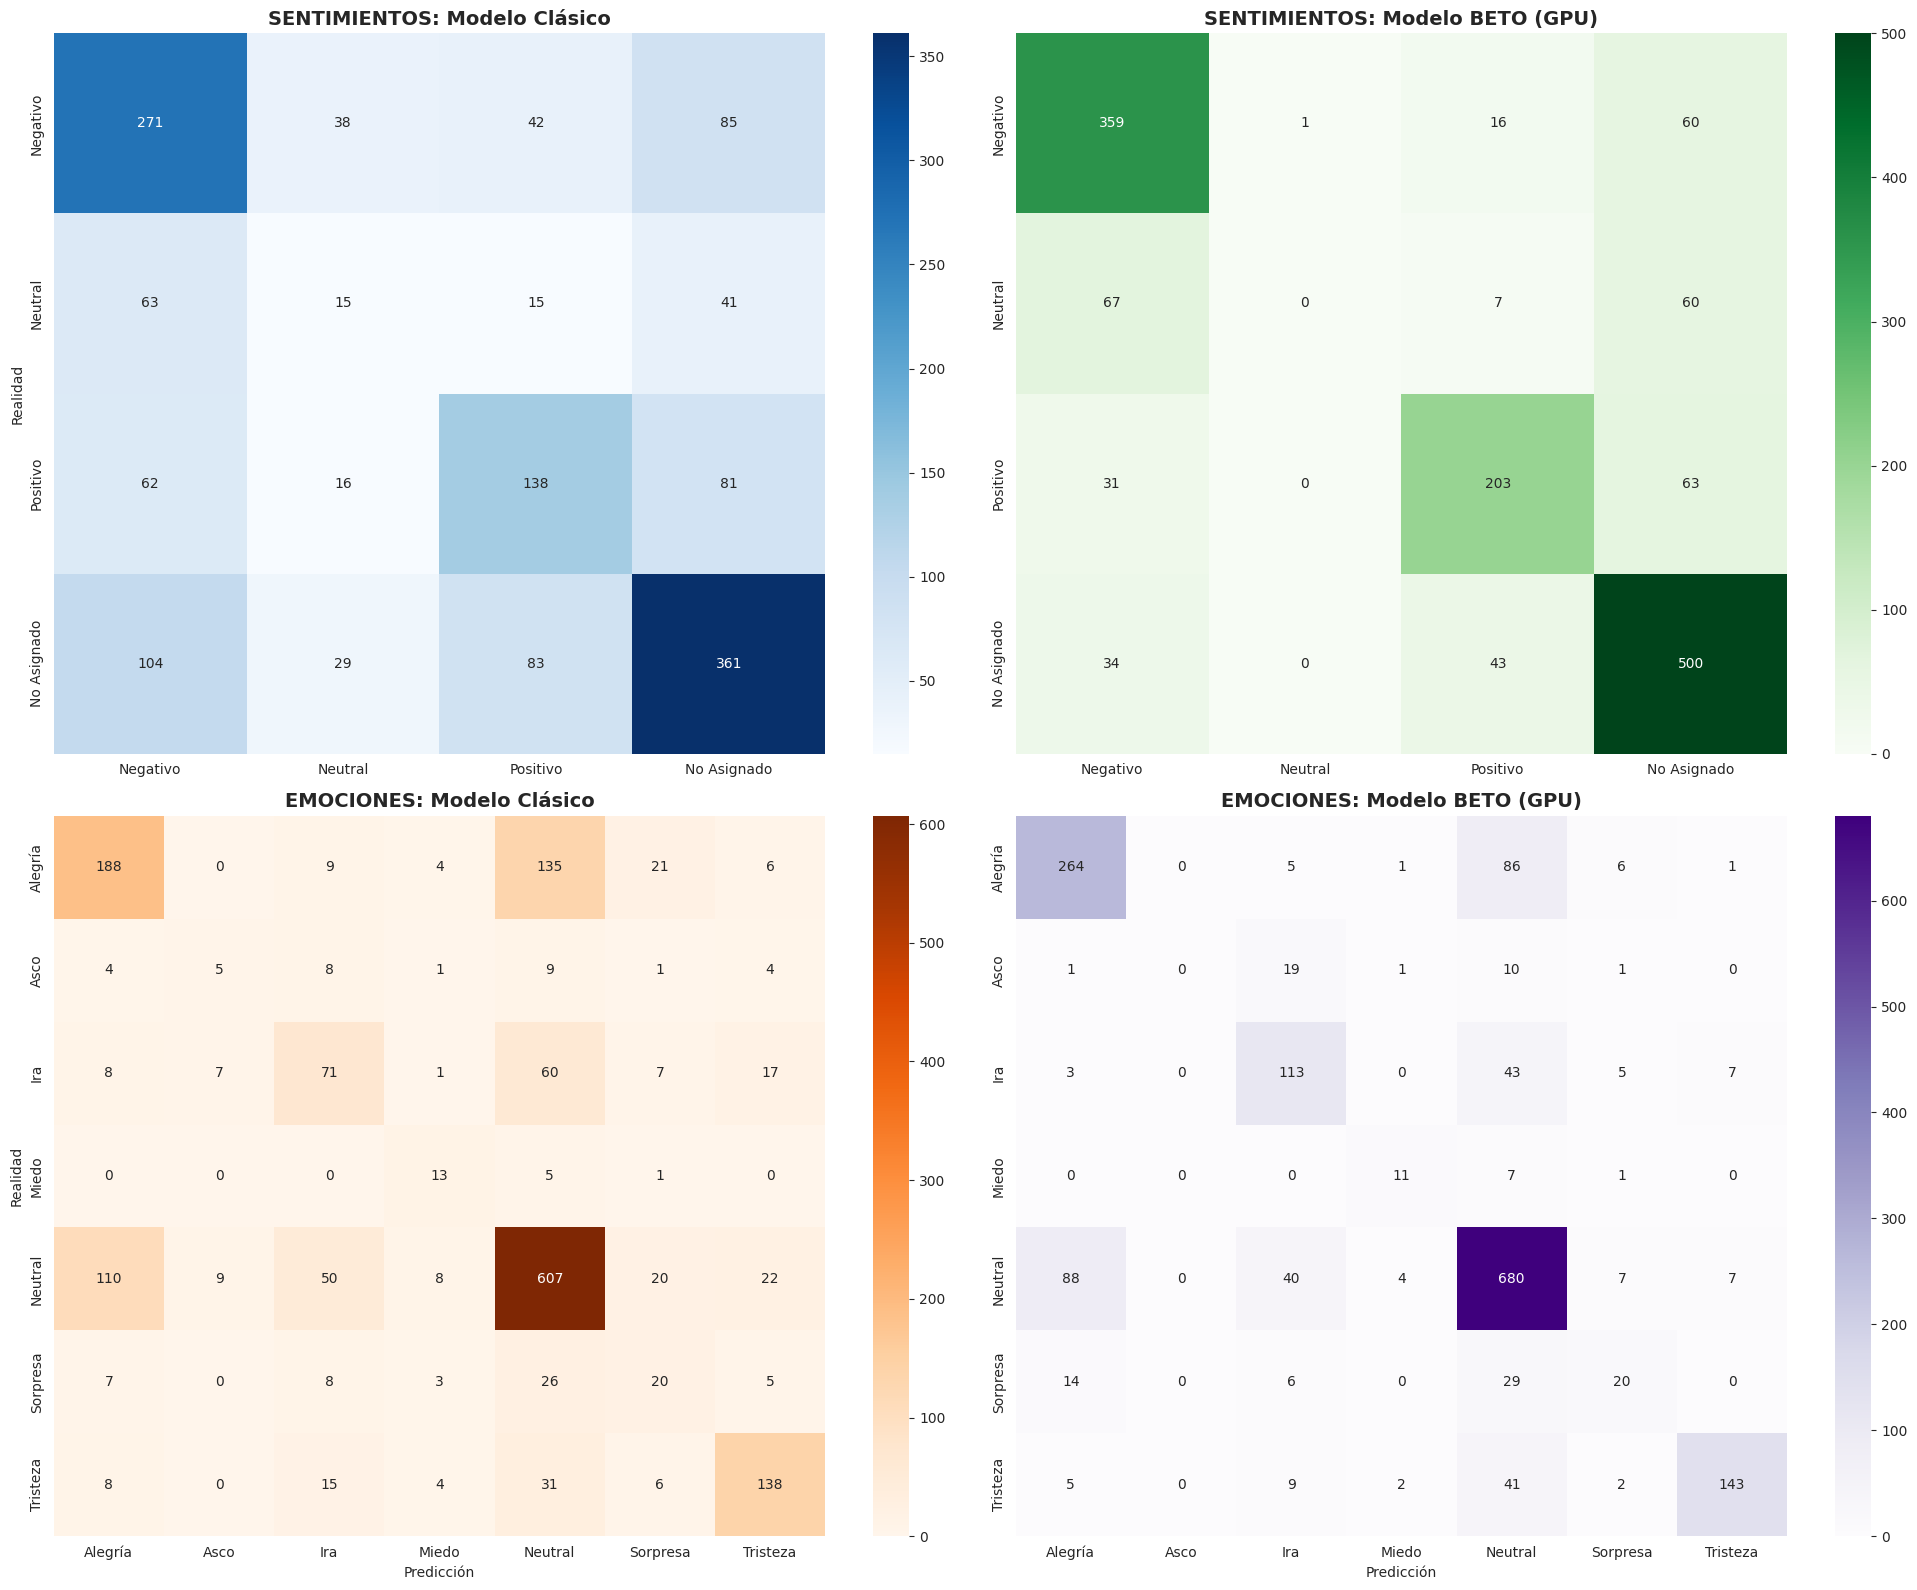


🔑 PALABRAS CLAVE: SENTIMIENTOS (InterTASS)
--------------------------------------------------------------------------------
[Negativo]: déficit, recortes, paro, impuestos, caso, corrupción, crisis, millones
[Neutral]: garzón, xq, reducir, huelga, encima, si, armas, moda
[Positivo]: portada, reunión, comenzamos, pic, málaga, entrevista, minutos, sesión
[No Asignado]: gracias, feliz, gran, enhorabuena, felicidades, bien, premio, grande

🔑 PALABRAS CLAVE: EMOCIONES (EmoEvent)
--------------------------------------------------------------------------------
[Alegría]: feliz, gracias, mejor, orgullosa, orgulloso, libre, amo, felicidades
[Asco]: asco, maduro, rata, mierda, jugador, pedo, desastre, tontos
[Ira]: mierda, puta, gilipollas, coño, vergüenza, gente, tonto, culpa
[Miedo]: miedo, nervios, preocupa, nerviosa, dejan, pasando, feo, alguien
[Neutral]: url, url url, levante, libro, cambio, claro, medio, cuál
[Sorpresa]: capítulo, serio, madre, shock, raro, impresionante, serie, respirar


In [11]:
# ==============================================================================
# FASE 4: EVALUACIÓN INTEGRAL, COMPARACIÓN Y ANÁLISIS DE PALABRAS CLAVE
# ==============================================================================

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Configuración de tamaño de gráficos
plt.rcParams['figure.figsize'] = (20, 12)

print("📊 INICIANDO PROCESO DE EVALUACIÓN FINAL...")
print("-" * 70)

# ==============================================================================
# 1. GENERACIÓN DE PREDICCIONES (INFERENCIA MASIVA EN SET DE PRUEBA)
# ==============================================================================

# --- A. SENTIMIENTOS (INTERTASS) ---
print("   -> Generando predicciones para SENTIMIENTOS...")
# 1. Clásico (Regresión Logística)
y_pred_cl_s = clf_sent.predict(X_test_tfidf_s)

# 2. Deep Learning (BETO)
# El trainer devuelve 'logits' (probabilidades crudas), usamos argmax para elegir la clase ganadora
raw_pred_s = trainer_s.predict(tokenized_test_s)
y_pred_dl_s = np.argmax(raw_pred_s.predictions, axis=-1)
y_true_s = raw_pred_s.label_ids # Etiquetas reales

# --- B. EMOCIONES (EMOEVENT) ---
print("   -> Generando predicciones para EMOCIONES...")
# 1. Clásico (Regresión Logística)
y_pred_cl_e = clf_emo.predict(X_test_tfidf_e)

# 2. Deep Learning (BETO)
raw_pred_e = trainer_e.predict(tokenized_test_e)
y_pred_dl_e = np.argmax(raw_pred_e.predictions, axis=-1)
y_true_e = raw_pred_e.label_ids # Etiquetas reales

# ==============================================================================
# 2. DEFINICIÓN DE ETIQUETAS LEGIBLES
# ==============================================================================
# Recuperamos los nombres de las clases (N=0, NEU=1, P=2, NONE=3)
nombres_sent = ['Negativo', 'Neutral', 'Positivo', 'No Asignado']

# Recuperamos nombres de emociones (ordenados por su ID numérico 0,1,2...)
# Usamos el mapa inverso que creamos en Fase 2 (map_emo)
nombres_emo = [k for k, v in sorted(map_emo.items(), key=lambda item: item[1])]

# ==============================================================================
# 3. REPORTES TÉCNICOS (MÉTRICAS DETALLADAS)
# ==============================================================================

print("\n" + "█"*40 + "\n   RESULTADOS: SENTIMIENTOS (INTERTASS)\n" + "█"*40)
print("\n--- MODELO CLÁSICO (BASELINE) ---")
print(classification_report(y_test_s, y_pred_cl_s, target_names=nombres_sent, digits=4))

print("\n--- MODELO DEEP LEARNING (BETO) ---")
print(classification_report(y_true_s, y_pred_dl_s, target_names=nombres_sent, digits=4))

print("\n" + "█"*40 + "\n   RESULTADOS: EMOCIONES (EMOEVENT)\n" + "█"*40)
print("\n--- MODELO CLÁSICO (BASELINE) ---")
print(classification_report(y_test_e, y_pred_cl_e, target_names=nombres_emo, digits=4))

print("\n--- MODELO DEEP LEARNING (BETO) ---")
print(classification_report(y_true_e, y_pred_dl_e, target_names=nombres_emo, digits=4))

# ==============================================================================
# 4. VISUALIZACIÓN: MATRICES DE CONFUSIÓN (GRID 2x2)
# ==============================================================================
print("\n🎨 GENERANDO MATRICES DE CONFUSIÓN COMPARATIVAS...")

fig, ax = plt.subplots(2, 2, figsize=(20, 16))

# --- FILA 1: SENTIMIENTOS ---
# Clásico
cm_s_cl = confusion_matrix(y_test_s, y_pred_cl_s)
sns.heatmap(cm_s_cl, annot=True, fmt='d', cmap='Blues', ax=ax[0,0],
            xticklabels=nombres_sent, yticklabels=nombres_sent)
ax[0,0].set_title('SENTIMIENTOS: Modelo Clásico', fontsize=14, fontweight='bold')
ax[0,0].set_ylabel('Realidad')

# BETO
cm_s_dl = confusion_matrix(y_true_s, y_pred_dl_s)
sns.heatmap(cm_s_dl, annot=True, fmt='d', cmap='Greens', ax=ax[0,1],
            xticklabels=nombres_sent, yticklabels=nombres_sent)
ax[0,1].set_title('SENTIMIENTOS: Modelo BETO (GPU)', fontsize=14, fontweight='bold')

# --- FILA 2: EMOCIONES ---
# Clásico
cm_e_cl = confusion_matrix(y_test_e, y_pred_cl_e)
sns.heatmap(cm_e_cl, annot=True, fmt='d', cmap='Oranges', ax=ax[1,0],
            xticklabels=nombres_emo, yticklabels=nombres_emo)
ax[1,0].set_title('EMOCIONES: Modelo Clásico', fontsize=14, fontweight='bold')
ax[1,0].set_ylabel('Realidad')
ax[1,0].set_xlabel('Predicción')

# BETO
cm_e_dl = confusion_matrix(y_true_e, y_pred_dl_e)
sns.heatmap(cm_e_dl, annot=True, fmt='d', cmap='Purples', ax=ax[1,1],
            xticklabels=nombres_emo, yticklabels=nombres_emo)
ax[1,1].set_title('EMOCIONES: Modelo BETO (GPU)', fontsize=14, fontweight='bold')
ax[1,1].set_xlabel('Predicción')

plt.tight_layout()
plt.show()

# ==============================================================================
# 5. INTERPRETABILIDAD: PALABRAS CLAVE (DEL MODELO CLÁSICO)
# ==============================================================================
# Analizamos los coeficientes de la Regresión Logística para entender qué palabras
# pesan más para cada clase.

def mostrar_top_palabras(modelo, vectorizador, etiquetas, titulo):
    print(f"\n🔑 PALABRAS CLAVE: {titulo}")
    print("-" * 80)
    feature_names = np.array(vectorizador.get_feature_names_out())
    coefs = modelo.coef_

    for idx, nombre in enumerate(etiquetas):
        # Top 10 palabras positivas (que más empujan hacia esta clase)
        top_indices = np.argsort(coefs[idx])[-8:][::-1]
        top_words = feature_names[top_indices]
        print(f"[{nombre}]: {', '.join(top_words)}")

# Ejecutar análisis
mostrar_top_palabras(clf_sent, vectorizer, nombres_sent, "SENTIMIENTOS (InterTASS)")
mostrar_top_palabras(clf_emo, vectorizer_emo, nombres_emo, "EMOCIONES (EmoEvent)")

print("\n✅ FASE 4 COMPLETADA.")

#Fase 5. Implementación práctica

•	Crear una interfaz simple (o script) donde el usuario ingrese un texto y el sistema:

1.	Clasifique su sentimiento.

2.	Muestre ambos resultados de manera conjunta.


In [13]:
# ==============================================================================
# FASE 5 - PARTE A: CONFIGURACIÓN Y PROCESAMIENTO MASIVO (SAMPLE)
# ==============================================================================

import torch
import pandas as pd
import numpy as np
import xmltodict
import os
from transformers import BertForSequenceClassification

# 1. CONFIGURACIÓN DE ETIQUETAS
# ------------------------------------------------------------------------------
# [cite_start]Mapa Sentimientos (Fijo) [cite: 1766-1770]
mapa_sent_inv = {0: 'NEGATIVO (N)', 1: 'NEUTRAL (NEU)', 2: 'POSITIVO (P)', 3: 'NO ASIGNADO (NONE)'}

# Mapa Emociones (Dinámico, recuperado de la Fase 2)
# Invertimos el diccionario map_emo: {0: 'Alegría', 1: 'Asco'...}
if 'map_emo' in globals():
    mapa_emo_inv = {v: k for k, v in map_emo.items()}
else:
    # Fallback por si se perdió la variable en memoria
    print("⚠️ Reconstruyendo mapa de emociones por defecto...")
    emociones_default = ['Alegría', 'Asco', 'Ira', 'Miedo', 'Neutral', 'Sorpresa', 'Tristeza']
    mapa_emo_inv = {i: e for i, e in enumerate(emociones_default)}

# 2. RECARGA DE MODELOS BETO (DESDE EL DISCO A LA GPU)
# ------------------------------------------------------------------------------
print("🔧 Cargando modelos neuronales desde el disco...")

try:
    # Cargar Modelo Sentimientos
    model_beto_s_final = BertForSequenceClassification.from_pretrained("./modelo_beto_sentimientos").to(device)
    model_beto_s_final.eval() # Modo evaluación (congela pesos)
    print("   -> ✅ Modelo Sentimientos cargado.")

    # Cargar Modelo Emociones
    model_beto_e_final = BertForSequenceClassification.from_pretrained("./modelo_beto_emociones").to(device)
    model_beto_e_final.eval()
    print("   -> ✅ Modelo Emociones cargado.")

except Exception as e:
    print(f"❌ Error cargando modelos: {e}")
    print("Asegúrate de haber ejecutado la Fase 3 completamente.")

# 3. FUNCIÓN MAESTRA DE PREDICCIÓN
# ------------------------------------------------------------------------------
def predecir_todo(texto):
    """
    Recibe texto y devuelve diccionario con predicciones de Sentimiento y Emoción.
    """
    res = {}

    # --- Preprocesamiento ---
    clean_beto = limpieza_para_beto(texto) # Usamos la función de la Fase 2

    # Tokenizar para BETO
    inputs = tokenizer(clean_beto, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

    # --- Inferencia Sentimientos ---
    with torch.no_grad():
        logits_s = model_beto_s_final(**inputs).logits
    idx_s = logits_s.argmax().item()
    conf_s = torch.nn.functional.softmax(logits_s, dim=-1)[0][idx_s].item()
    res['Sentimiento'] = mapa_sent_inv[idx_s]
    res['Conf_Sent'] = conf_s

    # --- Inferencia Emociones ---
    with torch.no_grad():
        logits_e = model_beto_e_final(**inputs).logits
    idx_e = logits_e.argmax().item()
    conf_e = torch.nn.functional.softmax(logits_e, dim=-1)[0][idx_e].item()
    res['Emoción'] = mapa_emo_inv[idx_e]
    res['Conf_Emo'] = conf_e

    return res

# 4. PROCESAMIENTO DEL ARCHIVO SAMPLE
# ------------------------------------------------------------------------------
ruta_sample = '/content/data/general-tweets-sample.xml'
print(f"\n📂 Analizando archivo de muestras: {ruta_sample}...")

if os.path.exists(ruta_sample):
    with open(ruta_sample, 'r', encoding='utf-8') as f:
        data_sample = xmltodict.parse(f.read())

    try:
        # Extracción de tweets
        if 'tweets' in data_sample: list_tw = data_sample['tweets']['tweet']
        else: list_tw = data_sample[list(data_sample.keys())[0]]['tweet']

        tabla_resultados = []

        print(f"   -> Procesando {len(list_tw)} tweets con IA...")

        for t in list_tw:
            contenido = t['content']
            pred = predecir_todo(contenido)

            # Formato solicitado en tu documento
            tabla_resultados.append({
                'Texto de entrada': contenido,
                'Sentimiento': f"{pred['Sentimiento']}",
                'Emoción': f"{pred['Emoción']}",
                'Confianza': f"S:{pred['Conf_Sent']:.2f} | E:{pred['Conf_Emo']:.2f}"
            })

        # Visualización
        df_res = pd.DataFrame(tabla_resultados)
        pd.set_option('display.max_colwidth', 100)
        print("\n📊 TABLA DE RESULTADOS (SAMPLE):")
        display(df_res)

    except Exception as e:
        print(f"❌ Error procesando XML: {e}")
else:
    print("⚠️ Archivo sample no encontrado.")

🔧 Cargando modelos neuronales desde el disco...
   -> ✅ Modelo Sentimientos cargado.
   -> ✅ Modelo Emociones cargado.

📂 Analizando archivo de muestras: /content/data/general-tweets-sample.xml...
   -> Procesando 33 tweets con IA...

📊 TABLA DE RESULTADOS (SAMPLE):


,Texto de entrada,Sentimiento,Emoción,Confianza
0,"'Portada 'Público', viernes. Fabra al banquillo por 'orden' del Supremo; Wikileaks 'retrata' a 1...",POSITIVO (P),Neutral,S:0.44 | E:0.98
1,"['Grande! RT @veronicacalderon ""El periodista es alguien que quiere contar la realidad, pero no ...",POSITIVO (P),Neutral,S:0.95 | E:0.85
2,"'Gonzalo Altozano tras la presentación de su libro 101 españoles y Dios. Divertido, emocionante ...",NO ASIGNADO (NONE),Alegría,S:0.97 | E:0.70
3,"'Mañana en Gaceta: TVE, la que pagamos tú y yo, culpa a una becaria de su falsa información sobr...",NEGATIVO (N),Neutral,S:0.92 | E:0.85
4,"'Qué envidia “@mfcastineiras: Pedro mañana x la mañana me voy a Paris, cuando esté por la almend...",NO ASIGNADO (NONE),Alegría,S:0.58 | E:0.70
5,'Más mañana en Gaceta. Amaiur depende de Uxue Barkos para crear grupo propio. ERC no cumple el r...,NEGATIVO (N),Neutral,S:0.79 | E:0.98
6,"'Muy buenas noches followercetes, mañana va a ser un día bastante mitico para mi, ya os contare....",NO ASIGNADO (NONE),Alegría,S:0.94 | E:0.76
7,'Más de mañana en Gaceta. UPyD contará casi seguro con grupo gracias al Foro Asturias. Eso se di...,NO ASIGNADO (NONE),Neutral,S:0.95 | E:0.88
8,"'La felicidad no esta en los grandes anhelos , sino con pequeñas cosas que ocurren todos los día...",NO ASIGNADO (NONE),Alegría,S:0.97 | E:0.72
9,'#ff para @pperezf,POSITIVO (P),Neutral,S:0.81 | E:0.92


#INPUT DE USUARIO

In [14]:
# ==============================================================================
# FASE 5 - PARTE B: LABORATORIO INTERACTIVO
# ==============================================================================

print("\n" + "█"*70)
print("🧪 LABORATORIO DE IA: CLASIFICADOR MULTI-TAREA")
print("   -> Detecta Sentimiento (P, N, NEU) y Emoción (Ira, Alegría, etc.)")
print("   -> Escribe 'salir' para terminar.")
print("█"*70)

while True:
    try:
        txt = input("\n📝 Tu frase: ")

        if txt.lower() in ['salir', 'exit', 'fin']:
            print("👋 ¡Hasta luego!")
            break

        if not txt.strip(): continue

        # Predicción en tiempo real
        resultado = predecir_todo(txt)

        print("-" * 60)
        # Formato visual tipo "Dashboard"
        print(f"🧠 ANÁLISIS DE TEXTO:")
        print(f"   \"{txt}\"")
        print("-" * 60)

        # Lógica de colores simple (usando iconos)
        icono_sent = "🟢" if "POSITIVO" in resultado['Sentimiento'] else "🔴" if "NEGATIVO" in resultado['Sentimiento'] else "⚪"

        print(f"{icono_sent} SENTIMIENTO:  {resultado['Sentimiento']}")
        print(f"   (Confianza: {resultado['Conf_Sent']:.2%})")
        print("-" * 60)

        print(f"❤️ EMOCIÓN:      {resultado['Emoción']}")
        print(f"   (Confianza: {resultado['Conf_Emo']:.2%})")
        print("=" * 60)

    except Exception as e:
        print(f"❌ Error en la predicción: {e}")


██████████████████████████████████████████████████████████████████████
🧪 LABORATORIO DE IA: CLASIFICADOR MULTI-TAREA
   -> Detecta Sentimiento (P, N, NEU) y Emoción (Ira, Alegría, etc.)
   -> Escribe 'salir' para terminar.
██████████████████████████████████████████████████████████████████████

📝 Tu frase: Estoy muy feliz con el resultado del partido
------------------------------------------------------------
🧠 ANÁLISIS DE TEXTO:
   "Estoy muy feliz con el resultado del partido"
------------------------------------------------------------
⚪ SENTIMIENTO:  NO ASIGNADO (NONE)
   (Confianza: 96.62%)
------------------------------------------------------------
❤️ EMOCIÓN:      Alegría
   (Confianza: 95.18%)

📝 Tu frase: Me siento triste por lo ocurrido
------------------------------------------------------------
🧠 ANÁLISIS DE TEXTO:
   "Me siento triste por lo ocurrido"
------------------------------------------------------------
🔴 SENTIMIENTO:  NEGATIVO (N)
   (Confianza: 82.84%)
--------